# Importing libraries and dependencies

In [15]:
# Install basemap
!pip install -q condacolab
!pip install -q condacolab basemap
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
!pip install basemap-data-hires

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import sklearn as sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load in data and create columns with one-hot encoding


In [16]:
# Read in data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hysteresis_data.csv').dropna()

# Transform lithology type into numeric data using one-hot encoding
data["t0_unbaked"] = (data['Type']==1).astype(int)
data["t1_baked"] = (data['Type']==2).astype(int)
data["t2_porcel"] = (data['Type']==3).astype(int)
data["t3_paralava"] = (data['Type']==4).astype(int)
data["t5_melt"] = (data['Type']==5).astype(int)
data["t6_ash"] = (data['Type']==6).astype(int)

# Transform color into numeric data using one-hot encoding
data["c0_yellow"] = ((data['Color_broad']>=1) & (data['Color_broad']<=4)).astype(int)
data["c1_orange"] = ((data['Color_broad']>=5) & (data['Color_broad']<=9)).astype(int)
data["c2_red"] = ((data['Color_broad']>=10) & (data['Color_broad']<=12)).astype(int)
data["c3_black"] = ((data['Color_broad']>=13) & (data['Color_broad']<=14)).astype(int)
data["c4_purple"] = (data['Color_broad']>=15).astype(int)
data["env_oxidizing"] = ((data['c1_orange']==1) | (data['c2_red']==1)).astype(int)
data["env_reducing"] = ((data['c3_black']==1) | data['c4_purple']==1).astype(int)

df = data.drop(columns=['Type', 'Color', 'Color_broad', 'specimen']) # Drop columns we won't need
df

,Lat,Lon,Ms,Mr,Mr/Ms,Bc,Bcr,Bcr/Bc,t0_unbaked,t1_baked,...,t3_paralava,t5_melt,t6_ash,c0_yellow,c1_orange,c2_red,c3_black,c4_purple,env_oxidizing,env_reducing
0,47.761901,-109.373392,0.1240,0.0462,0.37258,19.300,33.01721,1.71074,0,1,...,0,0,0,1,0,0,0,0,0,0
1,47.761901,-109.373392,0.1840,0.0735,0.39946,21.200,33.75919,1.59241,0,1,...,0,0,0,1,0,0,0,0,0,0
2,47.761901,-109.373392,0.0989,0.0388,0.39232,22.600,34.55576,1.52902,0,1,...,0,0,0,1,0,0,0,0,0,0
3,47.761901,-109.373392,0.0918,0.0274,0.29847,22.200,56.37728,2.53952,0,0,...,0,0,0,0,0,1,0,0,1,0
5,47.761901,-109.373392,0.0487,0.0210,0.43121,187.300,55.15684,0.29448,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,45.554233,-105.894850,2.2880,0.0300,0.01300,3.478,45.88100,13.19000,0,0,...,1,0,0,0,0,0,1,0,0,1
117,45.711233,-105.973133,0.1300,0.0500,0.38700,47.822,81.75000,1.70900,0,1,...,0,0,0,0,0,1,0,0,1,0
118,45.307617,-106.224717,0.2120,0.0950,0.45000,47.578,182.04700,3.82600,0,1,...,0,0,0,0,0,1,0,0,1,0
119,45.307617,-106.224717,0.1260,0.0700,0.55700,147.182,228.96700,1.55600,0,1,...,0,0,0,0,0,1,0,0,1,0


# K-Means Clustering

## Principal Component Analysis

In [17]:
# Normalize data
df_norm = (df - df.mean())/df.std()

In [18]:
# Create correlation and covariance matrices
corr = pd.DataFrame(df_norm).corr()
cov = pd.DataFrame(df_norm).cov()

In [19]:
# Inspect correlation matrix
corr.style.background_gradient(axis=None, vmin=0, vmax=abs(1.0), cmap='YlOrRd')

,Lat,Lon,Ms,Mr,Mr/Ms,Bc,Bcr,Bcr/Bc,t0_unbaked,t1_baked,t2_porcel,t3_paralava,t5_melt,t6_ash,c0_yellow,c1_orange,c2_red,c3_black,c4_purple,env_oxidizing,env_reducing
Lat,1.000000,-0.762543,-0.125476,-0.125446,-0.121040,-0.219737,-0.357066,0.185287,0.088434,-0.327771,0.467482,-0.289763,0.145295,-0.113866,0.008939,0.438390,-0.193367,-0.289763,-0.216432,0.290383,-0.375584
Lon,-0.762543,1.000000,0.050083,0.024598,-0.108928,-0.029941,0.058241,-0.080935,0.142336,-0.052322,-0.252509,0.255384,-0.050007,0.069814,0.004827,-0.141237,-0.084796,0.255384,0.067840,-0.212494,0.263030
Ms,-0.125476,0.050083,1.000000,0.948571,-0.075014,-0.050156,-0.043011,-0.022201,-0.103120,-0.086907,-0.053979,0.342364,-0.046706,-0.024188,-0.097667,-0.138149,-0.041647,0.342364,0.034774,-0.174457,0.321541
Mr,-0.125446,0.024598,0.948571,1.000000,0.012981,-0.011078,-0.009741,-0.057169,-0.107836,-0.014218,-0.049837,0.237662,-0.048871,-0.017299,-0.086823,-0.130686,0.003532,0.237662,0.080887,-0.130319,0.254598
Mr/Ms,-0.121040,-0.108928,-0.075014,0.012981,1.000000,0.482338,0.415077,-0.245640,-0.066414,0.218908,-0.030429,-0.161568,-0.078730,0.022005,0.025549,-0.067780,0.195694,-0.161568,0.006577,0.089169,-0.139026
Bc,-0.219737,-0.029941,-0.050156,-0.011078,0.482338,1.000000,0.724596,-0.170833,-0.040328,0.071266,-0.040933,-0.049389,-0.089912,0.242154,-0.031825,-0.208513,0.348539,-0.049389,-0.019519,0.069346,-0.054408
Bcr,-0.357066,0.058241,-0.043011,-0.009741,0.415077,0.724596,1.000000,-0.020876,-0.212551,0.219088,-0.067191,-0.023831,-0.098671,0.222074,-0.208378,-0.085125,0.350100,-0.023831,-0.018304,0.196347,-0.031168
Bcr/Bc,0.185287,-0.080935,-0.022201,-0.057169,-0.245640,-0.170833,-0.020876,1.000000,0.212662,-0.134792,-0.016892,0.008112,-0.017631,-0.038873,-0.068696,0.151781,-0.096145,0.008112,-0.059340,0.076928,-0.025663
t0_unbaked,0.088434,0.142336,-0.103120,-0.107836,-0.066414,-0.040328,-0.212551,0.212662,1.000000,-0.331007,-0.277980,-0.172396,-0.087469,-0.061246,0.685141,-0.223906,-0.213201,-0.172396,-0.098281,-0.400566,-0.206591
t1_baked,-0.327771,-0.052322,-0.086907,-0.014218,0.218908,0.071266,0.219088,-0.134792,-0.331007,1.000000,-0.476304,-0.295391,-0.149873,-0.104942,-0.079274,-0.011442,0.240335,-0.295391,0.203851,0.182676,-0.148065


In [20]:
# PCA
pca = PCA()
pca.fit(df_norm)

# Solve for PCs
PCs = pca.fit_transform(df_norm)

In [21]:
# Explained variance
pca_exp = pca.explained_variance_ratio_
PC_n = np.arange(1, len(pca_exp)+1, 1)

sum = np.sum(pca_exp[0:len(pca_exp)])

for i in range(len(pca_exp)):
    sum = np.sum(pca_exp[0:i])
    if 0 < sum < 0.95:
      print(i, f'components capture {sum:.2f}% of the variance.')
    elif sum > 0.90:
      print(i, 'components needed to capture at least 95% of the variance.')
      break

1 components capture 0.21% of the variance.
2 components capture 0.35% of the variance.
3 components capture 0.48% of the variance.
4 components capture 0.56% of the variance.
5 components capture 0.64% of the variance.
6 components capture 0.70% of the variance.
7 components capture 0.76% of the variance.
8 components capture 0.81% of the variance.
9 components capture 0.86% of the variance.
10 components capture 0.91% of the variance.
11 components capture 0.95% of the variance.
12 components needed to capture at least 95% of the variance.


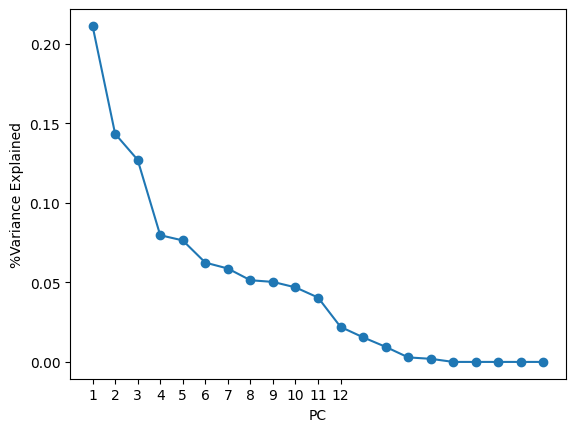

In [22]:
# Scree plot
plt.plot(PC_n, pca_exp, '-o')
plt.xlabel('PC')
plt.ylabel('%Variance Explained')
xticks = np.arange(1, 13, 1)
plt.xticks(xticks)
plt.show()

## Biplot

In [23]:
# This function will plot a biplot given principal components, loadings, and variable labels

def biplot(PCs,coef,labels=None):
    plt.figure(figsize=(10,10))
    xs = PCs[:,0] # PC1 (change indices for different PCs)
    ys = PCs[:,1] # PC2
    coef = np.transpose(coef)
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,
                s=15, 
                color='red')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")   
    plt.title('Biplot')
    plt.grid() 


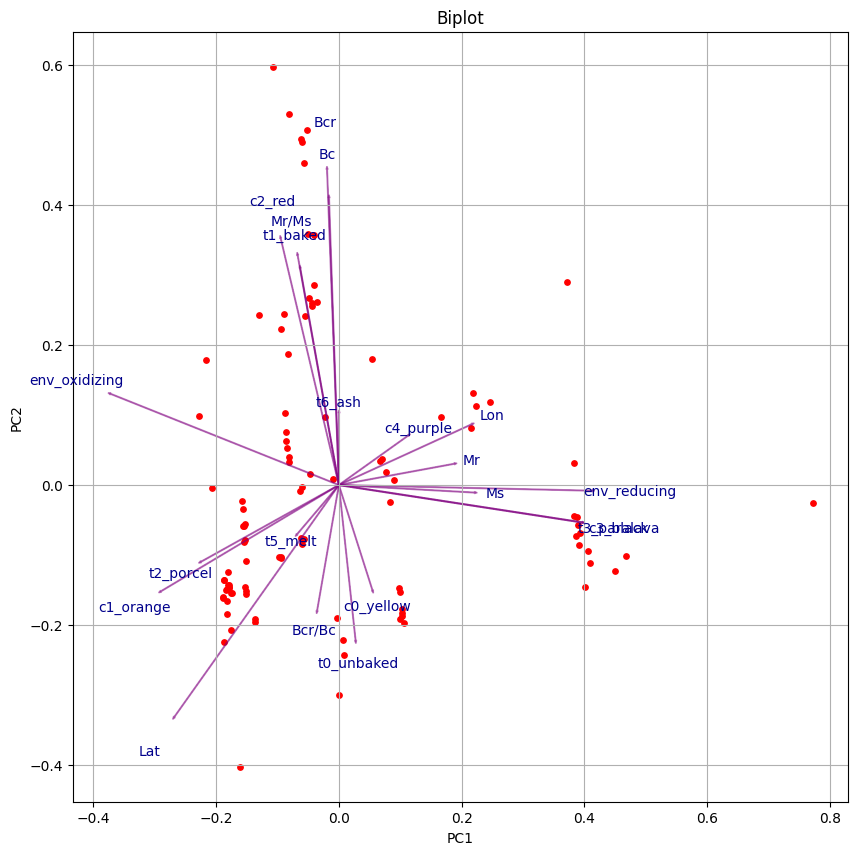

In [24]:
# Plot biplot
biplot(PCs, pca.components_, list(df.columns))

## Map PCs

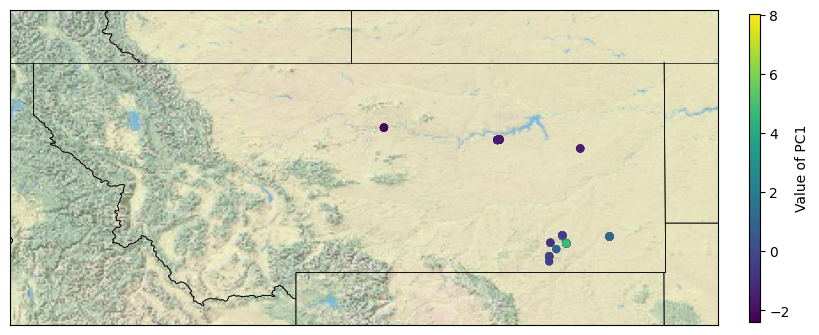

In [25]:
# Plot coordinates
plt.figure(figsize=(10,10))
m = Basemap(projection='mill',llcrnrlat=44,urcrnrlat=50,\
            llcrnrlon=-116.5,urcrnrlon=-103,resolution='h', epsg=4269)
m.arcgisimage(service='World_Physical_Map')
m.drawstates()
m.drawcountries()

x, y = m(df.Lon, df.Lat) # convert to polar stereographic
m.scatter(x, y, c=PCs[:, 0], cmap='viridis', s=25)
plt.colorbar(label='Value of PC1', fraction=0.046, shrink=0.4, aspect=30, pad=0.04)

plt.show()

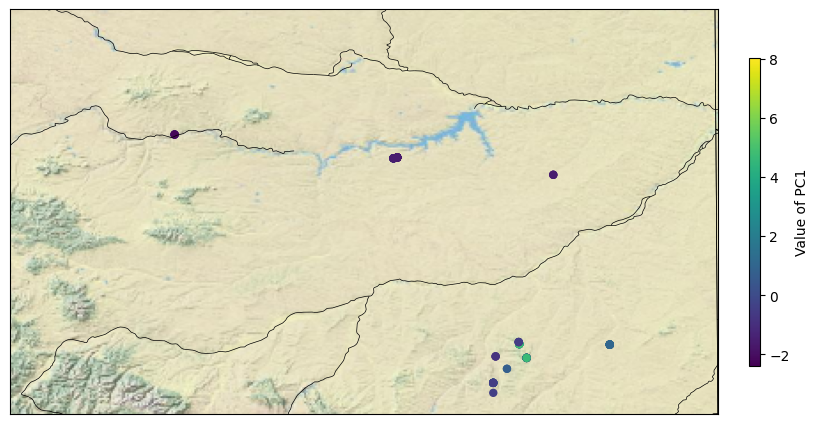

In [26]:
# Inset of plot with rivers plotted
plt.figure(figsize=(10,10))
m = Basemap(projection='mill',llcrnrlat=45,urcrnrlat=49,\
            llcrnrlon=-111,urcrnrlon=-104,resolution='h', epsg=4269)
m.arcgisimage(service='World_Physical_Map')
m.drawstates()
m.drawcountries()
m.drawrivers()

x, y = m(df.Lon, df.Lat) # convert to polar stereographic
m.scatter(x, y, c=PCs[:, 0], cmap='viridis', s=25)
plt.colorbar(label='Value of PC1', fraction=0.046, shrink=0.4, aspect=30, pad=0.04)

plt.show()

## K-means Clustering

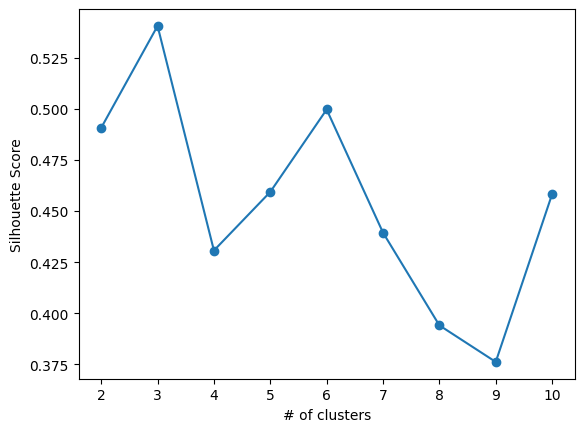

In [28]:
# Testing an array of silhouette scores
sc_list = []

for k in range(2, 11):
  kmeans_model = KMeans(n_clusters=k, random_state=42).fit(PCs[:,:13])
  sc=silhouette_score(PCs[:,:13], kmeans_model.labels_, metric='sqeuclidean')
  sc_list = np.append(sc, sc_list)

# Plotting silhouette scores
clusters = np.arange(2, 11, 1)
plt.plot(clusters, sc_list, '-o')
plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [29]:
# Modified biplot function

def biplot_clusters(PCs,coef, klabels, labels=None):
    plt.figure(figsize=(10,10))
    xs = PCs[:,0] # PC1 (change indices for different PCs)
    ys = PCs[:,1] # PC2
    coef = np.transpose(coef)
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex,ys * scaley, c = klabels, cmap='jet')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")   
    plt.title('Biplot') 
    plt.grid()

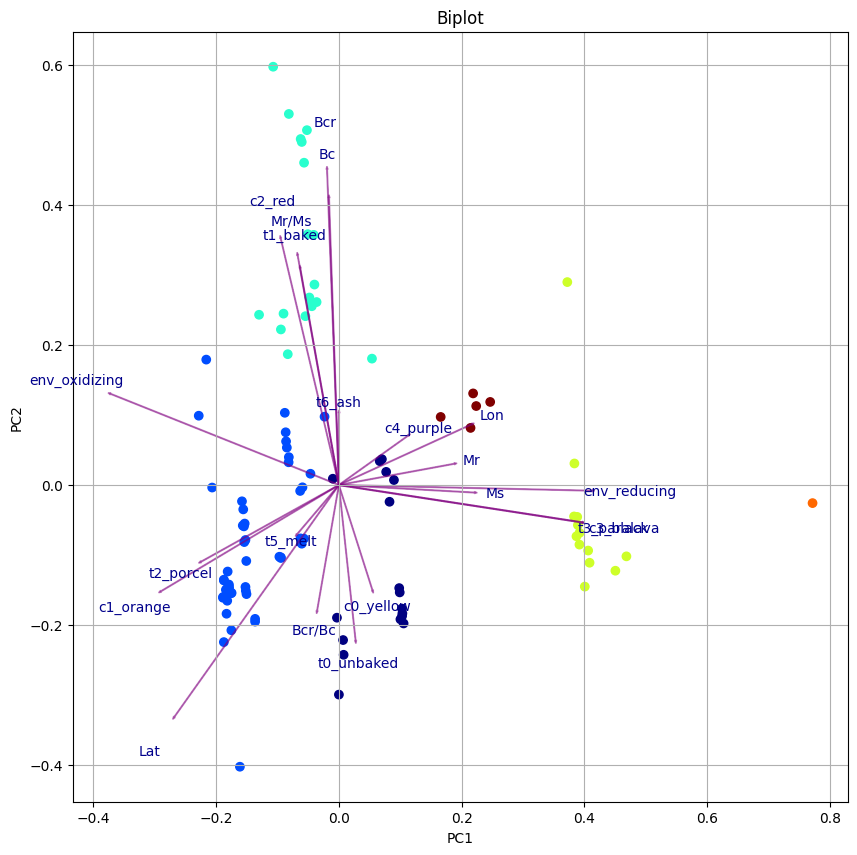

In [30]:
# kmeans clustering with optimal number of clusters
kmeans_optimal = KMeans(n_clusters=6, random_state=42).fit(PCs[:,:12]) #kmeans on first 12 PCs

# Plot modified biplot
biplot_clusters(PCs, pca.components_, kmeans_optimal.labels_, list(df.columns))


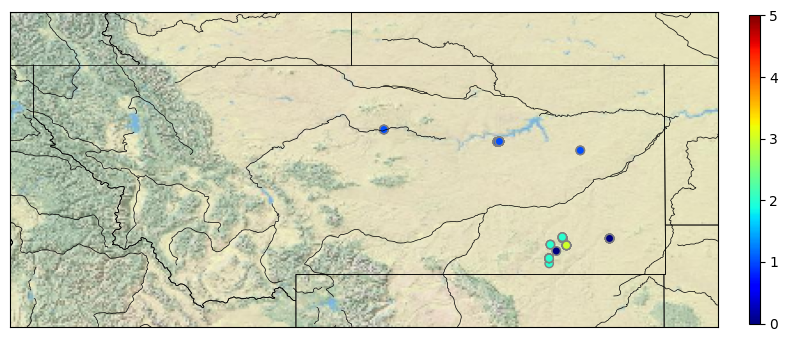

In [31]:
# Plot coordinates with kmeans labels
plt.figure(figsize=(10,10))
m = Basemap(projection='mill',llcrnrlat=44,urcrnrlat=50,\
            llcrnrlon=-116.5,urcrnrlon=-103,resolution='h', epsg=4269)
m.arcgisimage(service='World_Physical_Map')
m.drawstates()
m.drawcountries()
m.drawrivers()

x, y = m(data.Lon, data.Lat) # convert to polar stereographic
m.scatter(x, y, c=kmeans_optimal.labels_, cmap='jet', edgecolors='gray')
plt.colorbar(label='', fraction=0.046, shrink=0.4, aspect=30, pad=0.04)

plt.show()

## Plotly

In [32]:
# Use plotly for an interactive map to see closely clustered data points
# The transparency of the points helps when they are overlapping

import plotly.graph_objects as go

fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = df['Lon'],
        lat = df['Lat'],
        text = data['specimen'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.4,
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Jet',
            color = kmeans_optimal.labels_,
            colorbar_title=""
        )))

fig.update_layout(
        title = 'Clustered Clinker Data',
        geo = dict(
            scope='usa',
        ),
    )
fig.show()

# Classification

## Transform Bc into binary classifier to test

In [33]:
# Transform Bc into binary classifier using one-hot encoding
df['HC'] = (df['Bc']>=30)
df['HC'] = df['HC'].astype(int)

# Drop the rest of the magnetic data to focus on other characteristics
df = df.drop(columns=['Bc', 'Bcr', 'Bcr/Bc', 'Mr/Ms', 'Ms', 'Mr'])
df

,Lat,Lon,t0_unbaked,t1_baked,t2_porcel,t3_paralava,t5_melt,t6_ash,c0_yellow,c1_orange,c2_red,c3_black,c4_purple,env_oxidizing,env_reducing,HC
0,47.761901,-109.373392,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,47.761901,-109.373392,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,47.761901,-109.373392,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,47.761901,-109.373392,0,0,1,0,0,0,0,0,1,0,0,1,0,0
5,47.761901,-109.373392,0,0,1,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,45.554233,-105.894850,0,0,0,1,0,0,0,0,0,1,0,0,1,0
117,45.711233,-105.973133,0,1,0,0,0,0,0,0,1,0,0,1,0,1
118,45.307617,-106.224717,0,1,0,0,0,0,0,0,1,0,0,1,0,1
119,45.307617,-106.224717,0,1,0,0,0,0,0,0,1,0,0,1,0,1


## Split data into 80/20 train/test split

In [34]:
X = df.drop('HC', axis=1) # Features
y = df['HC'] # Labels

# 80% training datset and 20% test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

## Create and train RF model using training data

In [35]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Model with 100 trees

In [36]:
# Training the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Testing the model
y_pred = rf.predict(X_test)

## Compute feature importance

In [38]:
feat_imp_rf = pd.DataFrame({'Var' : X.columns, 'Importance' : rf.feature_importances_})
feat_imp_rf.nlargest(5, ['Importance'])

,Var,Importance
0,Lat,0.293902
1,Lon,0.166194
10,c2_red,0.147683
3,t1_baked,0.082920
9,c1_orange,0.063470


## Compute accuracy for test set

In [39]:
print("Model accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model accuracy:  0.8571428571428571
